In this notebook I use IRBEM to map each microburst to the magnetic equator.

In [1]:
import pandas as pd
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

import IRBEM

In [7]:
Re = 6371 # Earth radius, km

## Load the filtered catalog

In [6]:
CATALOG_VERSION = 6
CAT_PATH = ('/home/mike/research/ac6_microburst_scale_sizes/data/'
            'coincident_microbursts_catalogues/'
            'AC6_coincident_microbursts_sorted_v{}.txt'.format(CATALOG_VERSION))
cat = pd.read_csv(CAT_PATH)
cat.head()

,dateTime,dos1rate,peak_std,Lm_OPQ,MLT_OPQ,lat,lon,alt,Dist_In_Track,Lag_In_Track,Dist_Total,Loss_Cone_Type,flag,AE,time_cc,space_cc,time_spatial_A,time_spatial_B,peak_width_A,peak_width_B
0,2015-04-16 04:50:47.600000,560.003,5.242196,5.36905,21.77790,-71.3883,-121.5450,660.860,131.796,17.4919,131.804,1.0,0.0,583.0,0.815984,0.061890,2015-04-16 04:50:47.600000,2015-04-16 04:51:05.091900,0.175007,0.197500
1,2015-04-16 05:37:42.100000,569.946,6.014335,5.03621,10.06720,65.7251,53.1518,674.671,132.305,17.5961,132.313,1.0,0.0,552.0,0.903722,0.470579,2015-04-16 05:37:42.100000,2015-04-16 05:37:59.696100,0.295886,0.260770
2,2015-04-16 07:15:41.600000,730.004,4.564616,5.12112,10.36750,65.3316,28.9745,674.543,131.850,17.5372,131.858,1.0,0.0,618.0,0.810201,0.063204,2015-04-16 07:15:24.062800,2015-04-16 07:15:41.600000,0.305028,0.210672
3,2015-04-16 19:29:05.400000,2590.010,6.070891,5.41519,19.99470,-64.5365,26.2792,662.745,128.400,17.0482,128.409,0.0,4.0,1023.0,0.823308,0.494986,2015-04-16 19:29:05.400000,2015-04-16 19:29:22.448200,0.310256,0.317107
4,2015-04-16 20:17:02.100000,600.003,8.760751,4.19432,8.38166,61.3247,-163.4740,672.074,129.070,17.1628,129.077,1.0,0.0,1249.0,0.812830,-0.521795,2015-04-16 20:16:44.937200,2015-04-16 20:17:02.100000,0.316239,0.290001


Define a function to call IRBEM.find_magequator. This function takes a lat, lon, alt, dist_total arguments which it then splits into two sets of lat, lon, alt points assuming the dist_total is in latitude only (good assumption for polar orbiting spacecraft).

In [39]:
model = IRBEM.MagFields(kext='OPQ77')

def deltaLat(d, alt):
    """
    Calculate the half of the change in angle for a spacecraft at
    an altitude alt and separated by a distance d.
    """
    #dLat = 180/np.pi*d/(Re+alt)
    return np.rad2deg(np.arcsin(d/(2*(Re+alt))))

def map2equator(lat, lon, alt, time, d):
    """ Maps to magnetix equator assuming d is soly in latitude. """
    # Define the coordinates of the two spacecraft.
    dLat = deltaLat(d, alt)
    X1 = {'x1':alt, 'x2':lat-dLat, 'x3':lon, 'dateTime':time}
    X2 = {'x1':alt, 'x2':lat+dLat, 'x3':lon, 'dateTime':time}
    # Run IRBEM
    X1_equator = model.find_magequator(X1, None)['XGEO']
    X2_equator = model.find_magequator(X2, None)['XGEO']
    # Calculate the separations.
    d_equator = Re*np.linalg.norm(X1_equator-X2_equator)
    return d_equator

Calculate the scale sizes for all events in the sorted catalog.

In [40]:
d_equator = np.array([map2equator(row.lat, row.lon, row.alt, row.dateTime, row.Dist_Total) 
                      for _, row in cat.iterrows()])

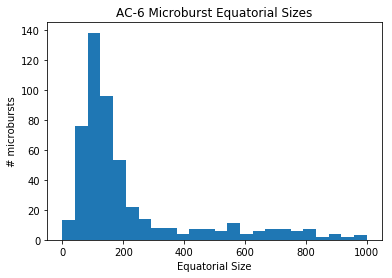

In [52]:
plt.hist(d_equator, bins=np.linspace(0, 1000, num=25))
plt.ylabel('# microbursts'); plt.xlabel('Equatorial Size'); plt.title('AC-6 Microburst Equatorial Sizes');

The above histogram is very close to the results by Santolik and Gurnett, 2003 "Transverse dimensions of chorus in the source region" paper. 

## Check
How would a 1 km sized microburst scales to the magnetic equator as a function of L shell?

In [88]:
lon = 180
lat_arr = np.linspace(60, 75)
time = '2019-03-18T00:00:00'
d_scale = np.array([map2equator(lat_i, lon, 500, time, 1) for lat_i in lat_arr])
output = model.make_lstar({'x1':500*np.ones_like(lat_arr), 'x2':lat_arr, 'x3':lon*np.ones_like(lat_arr), 
                  'dateTime':[time]*len(lat_arr)}, None)
output['Lm'] = np.abs(output['Lm'])

Mean MLT = 10.568432137166504


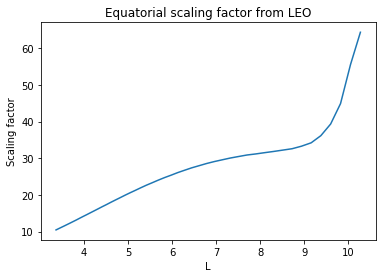

In [93]:
plt.plot(output['Lm'], d_scale); plt.xlabel('L'); plt.ylabel('Scaling factor'); 
plt.title('Equatorial scaling factor from LEO')
print('Mean MLT =', np.mean(output['MLT']))